In [1]:
import line_profiler
import pandas as pd
import uproot
#import uproot3
import numpy as np
# import track_time_calibration as ttc
from matplotlib import pyplot as plt
import sys
from tqdm import tqdm
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/tracking/')
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/utils/')
from track import Track
from track3D import Track3D
from hit import Hit
from data_loading import *
import scienceplots
plt.style.use(['science', 'grid', 'ieee'])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern Roman",
    'text.latex.preamble': [r'\usepackage{amsmath} \usepackage{amssymb} \usepackage{siunitx}'],
    'figure.dpi': 140,
    'font.size': 14,
    'axes.grid': True
})


In [2]:
file_path = '/Users/lucahartman/Documents/EPFL/MA1/project/data2/data_0000.root' ## later, one can use concatenation of data_0001.root - data_0008.root files as well. One is enough for testing

df_hits = load_dataset(file_path)
og_len = len(df_hits)
df_hits.query('n_hits > 8', inplace=True)
df_hits.query('n_hits < 50', inplace=True)
new_len = len(df_hits)
print('selected {:.2f}% of all events'.format(new_len/og_len * 100))

selected 13.94% of all events


In [3]:
## This function provide the parameters x0 (or y0 depending on which hits we provide) and tx the angle of the trac
def create_tracks(df, plot = False):
    tracks = []
    for index, row in tqdm(df.iterrows(), total = df.shape[0]):
        hits = [Hit(row,i) for i in range(row['n_hits'])]
        hitsX = [h for h in hits if h.is_sidex]
        hitsY = [h for h in hits if not h.is_sidex]
        
        ## Some events don't have three hits on one of the two sides and are thus not considered
        if len(hitsX) > 3 and len(hitsY) > 3:
            # get track parameters
            track = Track3D(hits)
            if track.is_good_2D_fit():
                tracks.append(track)

    return tracks

In [4]:
# getting tracks
import pickle
# tracks = create_tracks(df_hits)
# with open('angle.pkl', 'wb') as outp:
#     pickle.dump(tracks, outp, pickle.HIGHEST_PROTOCOL)
with open('angle.pkl', 'rb') as inp:
    tracks = pickle.load(inp)
tracks = tracks[:50000]
new_new_len = len(tracks)
print('selected {:.2f}% of all events'.format(new_new_len/new_len * 100))


selected 35.88% of all events


In [5]:
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/geant4/analysis')
from multiPreciseTracks import *

multiPreciseTracks(tracks)


In [6]:
# for t in tqdm(tracks, desc = 'precise tracks', leave = True):
#     t.precise_track()
# with open('angle_precise.pkl', 'wb') as outp:
#     pickle.dump(tracks, outp, pickle.HIGHEST_PROTOCOL)
with open('angle_precise.pkl', 'rb') as inp:
    tracks = pickle.load(inp)

In [123]:

thetas_x = [np.arctan(t.x.t) * 180 / np.pi for t in tracks if t.is_good_2D_fit()]
thetas_y = [np.arctan(t.y.t) * 180 / np.pi for t in tracks if t.is_good_2D_fit()]
print('ratio events = {}'.format(len(thetas_x) / 50000))

ratio events = 0.99908


In [117]:
import pickle
with open('geant4/analysis/data_acceptance_x.pkl', 'rb') as inp:
    [t_goodx, t_badx, n_goodx, n_badx] = pickle.load(inp)
with open('geant4/analysis/data_acceptance_y.pkl', 'rb') as inp:
    [t_goody, t_bady, n_goody, n_bady] = pickle.load(inp)
    
# cos^2 function
def cos2(x, A):
    return A * np.cos(np.pi*np.array(x)/180)**2

def correctionX(theta):
    corrs = np.zeros(np.shape(theta))
    theta = np.pi * np.array(theta) / 180
    for i in range(len(corrs)):
        if np.tan(theta[i]) < t_goodx[0]:
            corrs[i] = (n_goodx[0] / (n_goodx[0] + n_badx[0]))
        min_len = min(len(n_goodx), len(n_badx))
        for j in range(1, min_len):
            if t_goodx[j-1] < np.tan(theta[i]) and np.tan(theta[i]) < t_goodx[j]:
                corrs[i] = (n_goodx[j] / (n_goodx[j] + n_badx[j]))
        if np.tan(theta[i]) > t_goodx[-1]:
            corrs[i] = (n_goodx[-1] / (n_goodx[-1] + n_badx[-1]))
    return corrs

def expectedX(theta, A):
    return correctionX(theta) * cos2(theta, A)

def correctionY(theta):
    corrs = np.zeros(np.shape(theta))
    theta = np.pi * np.array(theta) / 180
    for i in range(len(corrs)):
        if np.tan(theta[i]) < t_goody[0]:
            corrs[i] = (n_goody[0] / (n_goody[0] + n_bady[0]))
        min_len = min(len(n_goody), len(n_bady))
        for j in range(1, min_len):
            if t_goody[j-1] < np.tan(theta[i]) and np.tan(theta[i]) < t_goody[j]:
                corrs[i] = (n_goody[j] / (n_goody[j] + n_bady[j]))
        if np.tan(theta[i]) > t_goody[-1]:
            corrs[i] = (n_goody[-1] / (n_goody[-1] + n_bady[-1]))
    return corrs

def expectedY(theta, A):
    return correctionY(theta) * cos2(theta, A)

def chi2(obs, exps, n_freedom):
    # print('obs ', np.array(obs))
    # print('exps ', np.array(exps))
    # print('diff ', np.array(obs) - np.array(exps))
    return (np.sum((np.array(obs) - np.array(exps))**2 / np.array(obs)) / n_freedom)

def manual_fitting(f, xs, ys, p0):
    best_chi2 = np.inf
    A = None
    for a in np.linspace(0, 2*p0, 2*p0):
        expected_ys = f(xs, a)
        c = chi2(ys, expected_ys, len(xs)-1)
        if c < best_chi2:
            best_chi2 = c
            A = a
    return A


X chi2 = 46.530 A =  8814.195 +-  192.497)
Y chi2 = 89.461 A =  8914.865 +-  197.378)


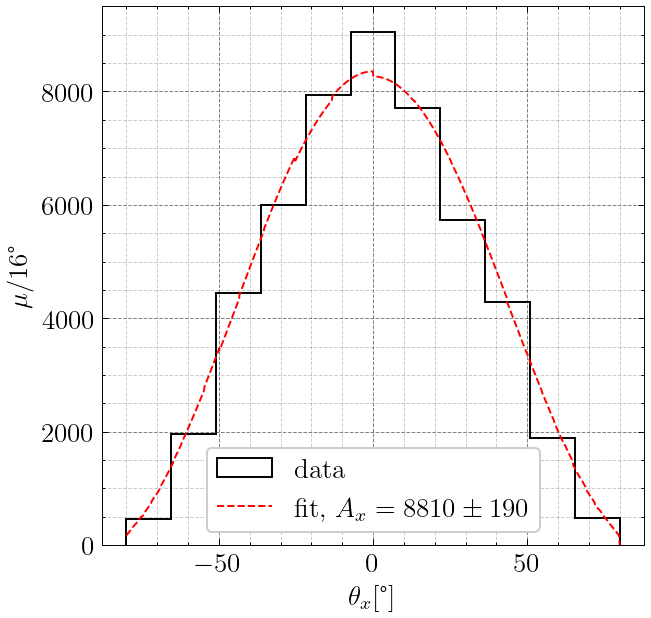

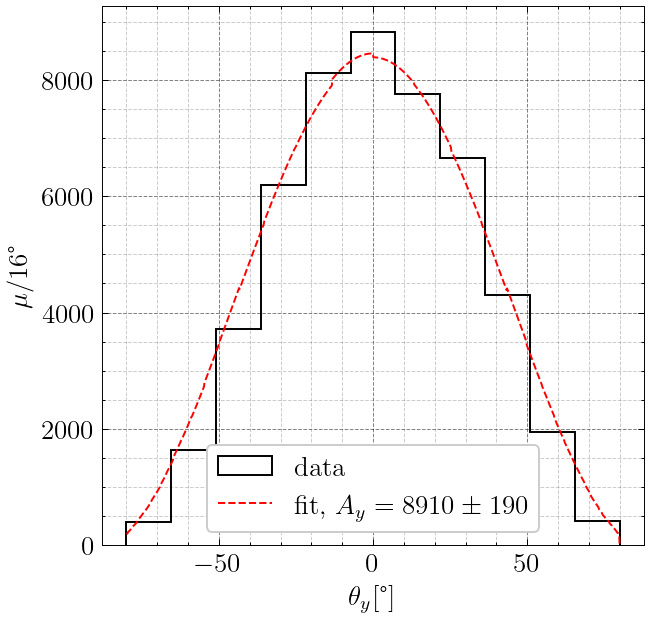

In [124]:
from scipy.optimize import curve_fit
bins = 11
guess_x = 8000
guess_y = 8000

xfit = np.linspace(-80, 80, 1000)
plt.figure(figsize=(5, 5))
n_x, xs, _ = plt.hist(thetas_x, bins = bins, range = [-80, 80], label = 'data', histtype = 'step')
xs = np.array(xs) + (xs[1] - xs[0])/2
# xfit = xs[:-1]
popt_x, pcov_x = curve_fit(expectedX, xs[:-1], n_x, bounds = (0, np.inf), p0 = guess_x)
# plt.plot(xfit, expectedX(xfit, popt_x[0]), label = 'fit, $A$ = ({:.0f}$\pm${:.3f})'.format(popt_x[0], np.sqrt(pcov_x[0, 0])))
plt.plot(xfit, expectedX(xfit, popt_x[0]), label = 'fit, $A_x = 8810\pm190$')
plt.xlabel(r'$\theta_x$[°]')
plt.ylabel(r'$\mu / 16$°')
plt.legend(loc = 'lower center')
plt.grid(which = 'major', alpha = 0.5)
plt.grid(which = 'minor', alpha = 0.2)
plt.savefig('../figs/angle_distributionX.pdf')
print('X chi2 = {:.3f}'.format(chi2(n_x, expectedX(xs[:-1], popt_x[0]), len(n_x)-1)), 'A = {: .3f} +- {: .3f})'.format(popt_x[0], np.sqrt(pcov_x[0, 0])))

plt.figure(figsize=(5, 5))
n_y, ys, _ = plt.hist(thetas_y, bins=bins, range=[-80, 80], label='data', histtype = 'step')
ys = np.array(ys) + (ys[1] - ys[0])/2
# xfit = ys[:-1]
popt_y, pcov_y = curve_fit(expectedY, ys[:-1], n_y, bounds = (0, np.inf), p0 = guess_y)
# plt.plot(xfit, expectedY(xfit, popt_y[0]), label='fit, $A$ = ({:.0f}$\pm${:.3f})'.format(popt_y[0], np.sqrt(pcov_y[0, 0])))
plt.plot(xfit, expectedY(xfit, popt_y[0]), label='fit, $A_y = 8910\pm190$')
plt.xlabel(r'$\theta_y$[°]')
plt.ylabel(r'$\mu / 16$°')
plt.legend(loc = 'lower center')
plt.grid(which = 'major', alpha = 0.5)
plt.grid(which = 'minor', alpha = 0.2)
plt.savefig('../figs/angle_distributionY.pdf')
print('Y chi2 = {:.3f}'.format(chi2(n_y, expectedX(ys[:-1], popt_y[0]), len(n_y)-1)), 'A = {: .3f} +- {: .3f})'.format(popt_y[0], np.sqrt(pcov_y[0, 0])))


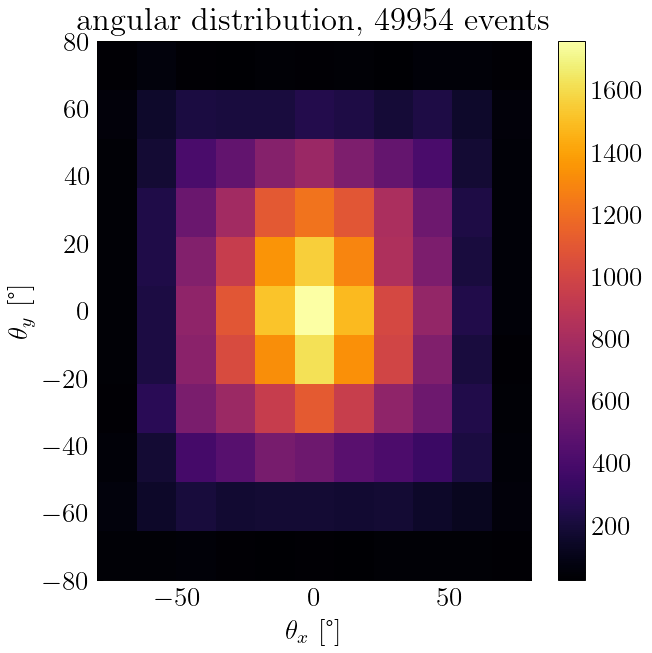

In [56]:
# 2D hist of angular distribution
plt.figure(figsize=(5, 5))
plt.title('angular distribution, {} events'.format(len(thetas_x)))
h, xs, ys, img = plt.hist2d(thetas_x, thetas_y, bins = 11, range = [[-80, 80], [-80, 80]], cmap = 'inferno')
plt.xlabel(r"$\theta_x$ [°]")
plt.ylabel(r"$\theta_y$ [°]")
plt.colorbar()